/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1193/1193 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


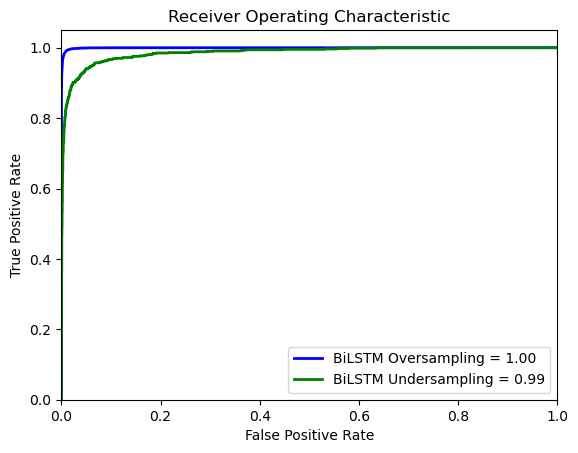

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Load and preprocess the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)
df.dropna(subset=['Base_Reviews'], inplace=True)  # Remove rows with NaN in 'Base_Reviews'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

# Define class labels
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3,
          'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# Check for NaN values in data
if np.isnan(X).any() or np.isnan(y).any():
    raise ValueError("Data or labels contain NaN values. Please ensure data preprocessing is correct.")

# Create oversampling and undersampling objects
oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Define the BiLSTM model
def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the models for oversampling and undersampling
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

model_bilstm_oversampling = create_bilstm_model()
model_bilstm_undersampling = create_bilstm_model()

model_bilstm_oversampling.fit(X_oversampled, y_oversampled, epochs=10, batch_size=32, verbose=0)
model_bilstm_undersampling.fit(X_undersampled, y_undersampled, epochs=10, batch_size=32, verbose=0)

# Function to plot ROC curve and calculate AUC
def plot_roc_auc(model, X, y, title, color):
    plt.title('Receiver Operating Characteristic')
    y_pred = model.predict(X)
    fpr, tpr, thresholds = roc_curve(y.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{title} = {roc_auc:.2f}", lw=2, alpha=1)

# Plot ROC curves for BiLSTM models with oversampling and undersampling
plot_roc_auc(model_bilstm_oversampling, X_oversampled, y_oversampled, 'BiLSTM Oversampling', 'blue')
plot_roc_auc(model_bilstm_undersampling, X_undersampled, y_undersampled, 'BiLSTM Undersampling', 'green')

plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('BiLSTM_ROC_over.png', dpi=300)
plt.show()
